In [1]:
import json
import logging
import numpy as np
import pandas as pd
logger = logging.getLogger(__name__)


import radix_cache as rc
import time

from matplotlib import pyplot as plt
import seaborn as sns

class QwenDatasets:
    def __init__(self, datapath="../data/qwen-bailian-usagetraces-anon"):
        with open(datapath+"/qwen_traceA_blksz_16.jsonl", "r") as f:
            self.trace_a = f.readlines()
        self.trace_a_size = len(self.trace_a)
        
        with open(datapath+"/qwen_traceB_blksz_16.jsonl", "r") as f:
            self.trace_b = f.readlines()
        self.trace_b_size = len(self.trace_b)
        
        logger.warning(f"loading trace A/B from {datapath}, trace_a_size={self.trace_a_size}, trace_b_size={self.trace_b_size}")
    
    def trace_a(self, idx = None):
        if idx is None:
            idx = 0
            logger.info()
        return self.trace_a
        
    def trace_b(self):
        return self.trace_b

def line_parser(line: str):
        sample = json.loads(line)
        return sample["hash_ids"], sample["timestamp"]
def radix_with_qwen_simulation(data):
    page_size = 1 # already given block hash, no need to convert
    timestamp = 0
    tree = rc.RadixCache(page_size=page_size, disable=False, timestamp=timestamp)
    timer = []
    stats_list = []
    ts_list = []
    tstart = time.time()
    timer.append(tstart)
    for line in data:
        hash_ids, timestamp = line_parser(line)
        prefix, _ = tree.match_prefix(key=hash_ids, timestamp=timestamp)
        tree.insert(key=hash_ids, timestamp=timestamp)
        # collect metrics
        stats_list.append([len(hash_ids), len(prefix)])
        # stats = tree.get_stats()
        # stats_list.append([stats.num_queries, stats.num_hits])
        max_timestamp = timestamp
        ts_list.append(timestamp)
        # timer
        tend = time.time()
        timer.append(tend)

    # tree.show_stats()
    # retrieve time is iv not update incorrect; too expensive for each search
    tree.update_cache_status(cur_time=max_timestamp) 
    # tree.pretty_print()
    tree.show_stats()
    print("Finish in {:0.2f} sec, with total {} samples".format(tend - tstart, len(data)))
    # return tree.get_stats()
    return stats_list, ts_list, tree.get_stats()

qwen_data = QwenDatasets()

trace_a = qwen_data.trace_a
stats_a, ts_a, summary_a = radix_with_qwen_simulation(trace_a)

trace_b = qwen_data.trace_b
stats_b, ts_b, summary_b = radix_with_qwen_simulation(trace_b)

loading trace A/B from ../data/qwen-bailian-usagetraces-anon, trace_a_size=43058, trace_b_size=172800


num_queries = 6293976
num_hits = 3637576
hit_rate = 57.79%
num_actives = 1196596
num_stores = 2656400
active_rate = 45.05%
retrieve_time_list = [7199.361, 7197.588, 7197.392, 7189.528, 2041.748, 7186.025, 0.0, 146.676, 7018.235000000001, 6491.321]
max_retrieve_time = 7199.361
store_duration_list = [7199.464, 7199.258, 7197.558, 7196.861, 7192.4619999999995, 7186.025, 7181.001, 7180.755, 7174.341, 7167.7119999999995]
max_store_duration = 7199.464
Finish in 2.42 sec, with total 43058 samples
num_queries = 9956137
num_hits = 5317759
hit_rate = 53.41%
num_actives = 130770
num_stores = 4638378
active_rate = 2.82%
retrieve_time_list = [7199.907, 6880.29, 7152.478999999999, 7196.671, 7197.084, 7188.118, 7199.458, 3551.297, 7031.696999999999, 0.0]
max_retrieve_time = 7199.907
store_duration_list = [7199.97, 7199.963000000001, 7199.95, 7199.934, 7199.917, 7199.832, 7199.776, 7199.711, 7199.611, 7199.586]
max_store_duration = 7199.97
Finish in 5.73 sec, with total 172800 samples


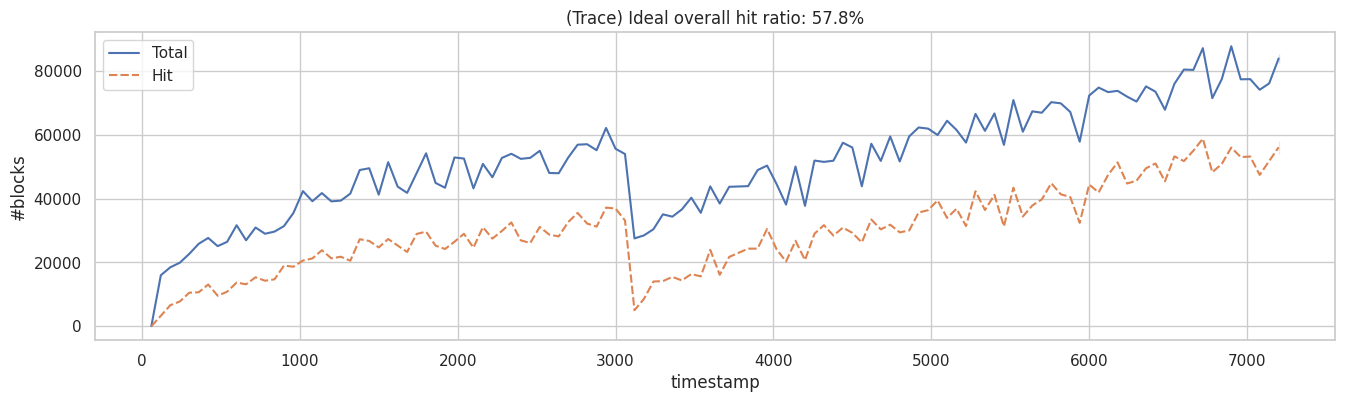

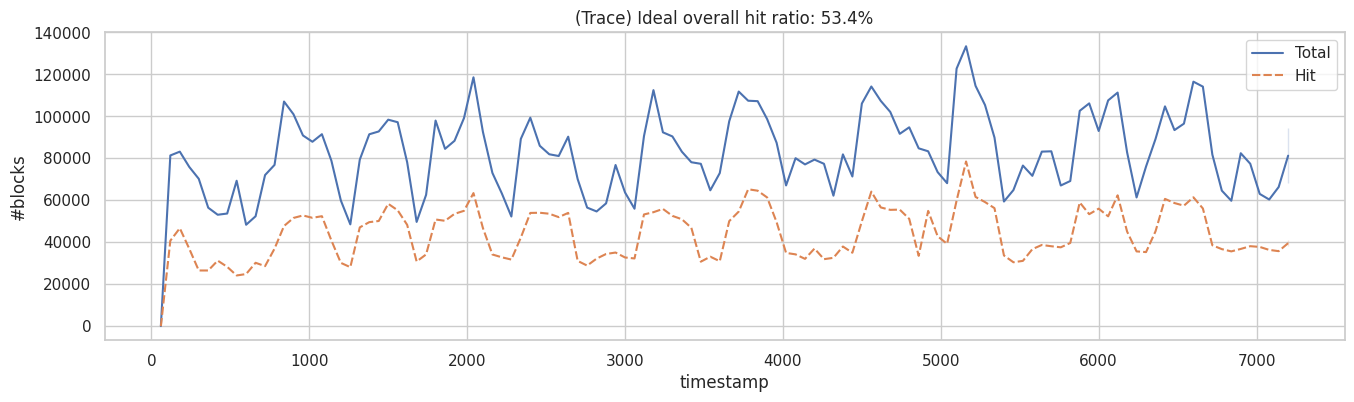

In [10]:
def bin_data(stats_list, ts_list, summary, tag="Trace",ts_step=60, ts_init=0):
    assert len(stats_list) == len(ts_list)
    ts_limit = ts_init
    num_queries_sum = 0
    num_hits_sum = 0
    ret_stats = []
    ret_ts = []
    for idx in range(len(ts_list)):
        ts = ts_list[idx]
        stats = stats_list[idx]
        while ts > ts_limit:
            ts_limit += ts_step
            ret_stats.append([num_queries_sum, num_hits_sum])
            ret_ts.append(ts_limit)
            num_queries_sum = 0
            num_hits_sum = 0
        num_queries_sum += stats[0]
        num_hits_sum += stats[1]
    ret_stats.append([num_queries_sum, num_hits_sum])
    ret_ts.append(ts_limit)
    df = pd.DataFrame(np.array(ret_stats), index=ret_ts, columns=["Total", "Hit"])
    plt.figure(figsize=(16,4))
    sns.set_theme(style="whitegrid")
    sns.lineplot(df)
    plt.title("({}) Ideal overall hit ratio: {:0.1f}%".format(tag, summary.num_hits / summary.num_queries * 100))
    plt.xlabel("timestamp")
    plt.ylabel("#blocks")
    return df

ts_step = 60
df_a = bin_data(stats_a, ts_a, summary_a, ts_step=ts_step)
df_b = bin_data(stats_b, ts_b, summary_b, ts_step=ts_step)


In [7]:
plt.xlabel

<function matplotlib.pyplot.xlabel(xlabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['left', 'center', 'right'] | None" = None, **kwargs) -> 'Text'>

In [3]:
df_a = pd.DataFrame(np.array(stats_a), index=ts_a, columns=["num_queries", "num_hits"])
df_b = pd.DataFrame(np.array(stats_b), index=ts_b, columns=["num_queries", "num_hits"])

In [9]:
num_line = 0
num_q = 0
qtimes = []
for line in trace_a:
    hash_ids, timestamp = line_parser(line)
    num_line += 1
    num_q += len(hash_ids)
    qtimes.append(timestamp)
print(num_line, num_q)

43058 6293976
